In [259]:
import cv2
import glob
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

from random import shuffle

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from skimage.feature import peak_local_max
from skimage import data, img_as_float, filters
from skimage.morphology import erosion, dilation, opening, closing
from skimage.morphology import square

from scipy.ndimage.filters import convolve
from scipy.ndimage.measurements import label
from scipy import ndimage as ndi
from scipy.special import expit as sigmoid

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Load Dataset

In [2]:
cars = glob.glob('dataset/vehicles/*/*.png')
notcars = glob.glob('dataset/non-vehicles/*/*.png')

print('Car Images:  ', len(cars))
print('Other Images:', len(notcars))

Car Images:   8792
Other Images: 8968


### Visualize Dataset

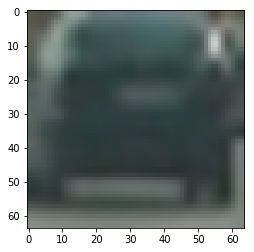

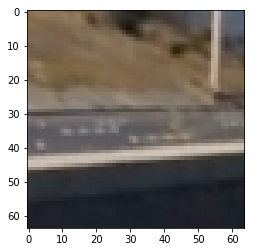

In [3]:
car = mpimg.imread(cars[0])
notcar = mpimg.imread(notcars[0])
plt.imshow(car)
plt.show()
plt.imshow(notcar)

In [4]:
def get_hog(img, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  visualise=vis, feature_vector=feature_vec, transform_sqrt=True)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       visualise=vis, feature_vector=feature_vec,transform_sqrt=True)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, cspace='YUV', orient=11, 
                        pix_per_cell=16, cell_per_block=2, hog_channel='ALL'):
    # Dictionary containing color conversions
    color = {'HSV':cv2.COLOR_RGB2HSV, 'HLS':cv2.COLOR_RGB2HLS, 'YUV':cv2.COLOR_RGB2YUV, 'LAB':cv2.COLOR_RGB2LAB, 'LUV':cv2.COLOR_RGB2LUV}

    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        image = cv2.resize(image, (64,64))
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            feature_image = cv2.cvtColor(image, color[cspace])
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

def extract_features_single(img, cspace='YUV', orient=11, 
                        pix_per_cell=16, cell_per_block=2, hog_channel='ALL'):
    # Dictionary containing color conversions
    color = {'HSV':cv2.COLOR_RGB2HSV, 'HLS':cv2.COLOR_RGB2HLS, 'YUV':cv2.COLOR_RGB2YUV, 'LAB':cv2.COLOR_RGB2LAB, 'LUV':cv2.COLOR_RGB2LUV}

    # Create a list to append feature vectors to
    features = []
    # Read in each one by one
    image = cv2.resize(img, (64,64))
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        feature_image = cv2.cvtColor(image, color[cspace])
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Append the new feature vector to the features list
    features.append(hog_features)
    # Return list of feature vectors
    return features

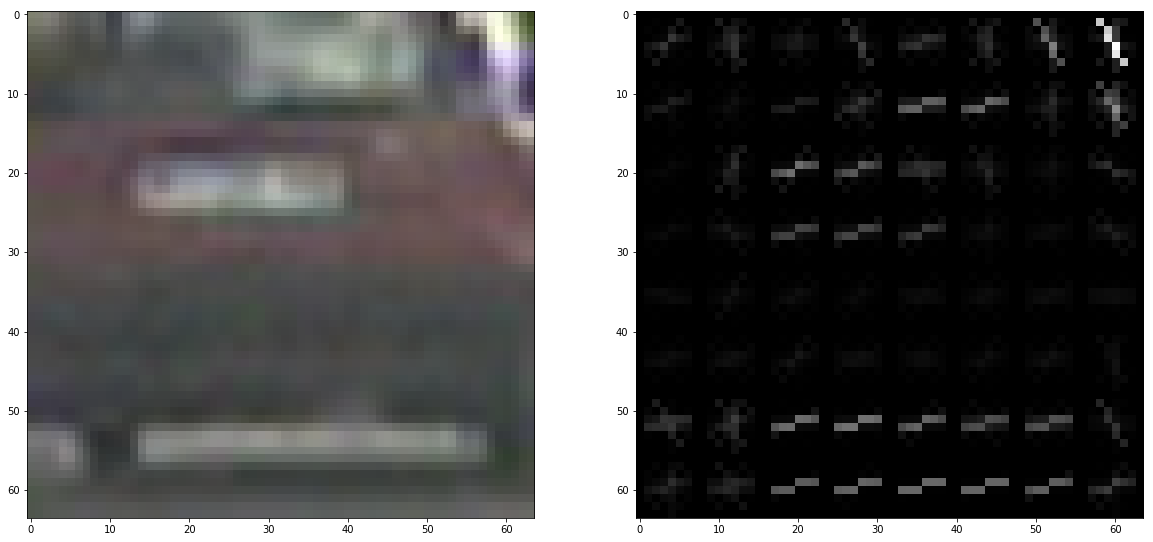

In [5]:
car = mpimg.imread(cars[120])
gray = cv2.cvtColor(car, cv2.COLOR_RGB2GRAY)
feat, imhog = get_hog(gray, vis=True)
fig = plt.figure(figsize = (20,20))
plt.subplot(121)
plt.imshow(car)
plt.subplot(122)
plt.imshow(imhog, cmap='gray')

In [6]:
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 1000
cars = cars[0:sample_size]
notcars = notcars[:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, LAB
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

6.3 Seconds to extract HOG features...


In [7]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

min_scaled = np.min(X_scaler.transform(X))
max_scaled = np.max(X_scaler.transform(X))


print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188
0.34 Seconds to train SVC...
Test Accuracy of SVC =  0.97
My SVC predicts:  [ 0.  0.  1.  1.  0.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  1.  0.  1.  1.  0.]
0.00238 Seconds to predict 10 labels with SVC


320 windows


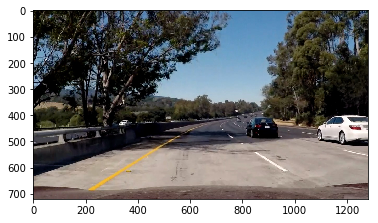

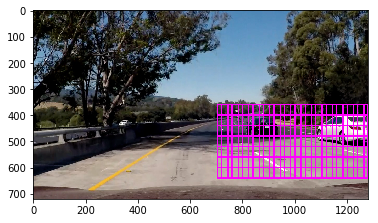

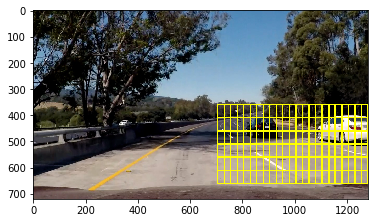

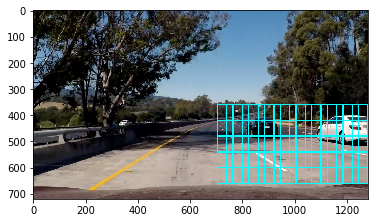

In [9]:
def get_windows(img, sizes=[100, 150, 175], overlap=.5, y_start_stop=(.5, .94), x_start_stop=(0.55, 1)):
    ''' "sizes" are the square dimensions of the windows we will tile
        "y_start_stop" and "x_stop_stop" are passed in as percentages of the image '''
    
    y_size, x_size = img.shape[:2]
    
    x_start = int(x_start_stop[0]*x_size)
    x_stop = int(x_start_stop[1]*x_size)
    y_start = int(y_start_stop[0]*y_size)
    y_stop = int(y_start_stop[1]*y_size)
    
    windows = []  # windows will be stored in this array as a tuple of tuples representing top-left and bottom-right window coordinates
    for size in sizes:
        step = int(size*(1-overlap))
        for y in range(y_start, y_stop-size, step):
            for x in range(x_start, x_stop-size, step):  # Windows tiled from the left
                windows.append(((x, y), (x+size, y+size)))
            for x in range(x_stop, x_start+size, -step):  # Windows tiled from the right
                windows.append(((x-size, y), (x, y+size)))
               
    return windows
    
    
# Draws bounding boxes
def draw_boxes(img, boxes, color=(0, 0, 255), thickness=4):
    imcopy = np.copy(img)
    for box in boxes:
        cv2.rectangle(imcopy, box[0], box[1], color, thickness)
        
    return imcopy

def draw_detected_boxes(img, boxes, color=(0, 0, 255), thickness=4):
    imcopy = np.copy(img)
    for box in boxes:
        cv2.rectangle(imcopy, box[0], box[1], color, thickness)
        
    return imcopy

image = mpimg.imread('./test_images/test5.jpg')
draw_img = np.copy(image)
boxes_1 = get_windows(image, sizes=[80])
boxes_2 = get_windows(image, sizes=[100])
boxes_3 = get_windows(image, sizes=[120])
draw_img_s = draw_boxes(draw_img, boxes_1, color=(255, 0, 255), thickness=3)
draw_img_m = draw_boxes(draw_img, boxes_2, color=(255, 255, 0), thickness=3)
draw_img_l = draw_boxes(draw_img, boxes_3, color=(0, 255, 255), thickness=3)

windows = np.concatenate((boxes_1, boxes_2, boxes_3))
print(len(windows), 'windows')

plt.imshow(draw_img)
plt.show()
plt.imshow(draw_img_s)
plt.show()
plt.imshow(draw_img_m)
plt.show()
plt.imshow(draw_img_l)
plt.show()

In [10]:
get = extract_features(imgs = [cars[120]], cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
get = X_scaler.transform(get)
print(svc.predict(get))

[ 1.]


In [491]:
def detect_car(img, window, scaler, scalemin=0, scalemax=1000):
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, LAB
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    top_l, bottom_r = window[0], window[1]
    crop_img = img[top_l[1]:bottom_r[1], top_l[0]:bottom_r[0],:] # Crop img to window
    plt.imshow(crop_img)
    features = extract_features_single(crop_img,cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    features_scaled = scaler.transform(features) # Normalization
    features_scaled = np.clip(features_scaled, scalemin, scalemax)
    out = svc.predict(features_scaled) == 1
    return out

def heatmap(img, boxes, min_thresh=0):
    heat = np.zeros_like(img[:,:,0])
    #heat = np.float32(heat)
    for box in boxes:
        top_l, bottom_r = box[0],box[1]
        heat[top_l[1]:bottom_r[1], top_l[0]:bottom_r[0]] += 1
        heat[(heat > 255)] = 255
    #kernel = np.ones((20,20), np.uint8)
    #heat = dilation(heat, square(30))
    heat[(heat < min_thresh)] = 0
    #heat = np.multiply(1-np.divide(1, (np.sqrt(heat))+ 1), 255)


    #heat = cv2.blur(heat, ksize=(5,5))
    #heat = ndi.maximum_filter(heat, size=5, mode='constant')
    return heat
    

224 windows


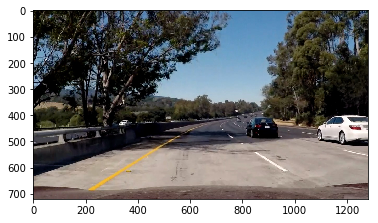

In [542]:
def draw_heatmap_boxes(img, heat, min_size=0):
    label_img, n_items = label(heat)
    # Iterate through all detected cars
    for car_number in range(1, n_items+1):
        # Find pixels with each car_number label value
        nonzero = (label_img == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        box = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        if (np.subtract(box[1][1],box[0][1]) >= min_size) & (np.subtract(box[1][0],box[0][0]) >= min_size):
            cv2.rectangle(img, box[0], box[1], (0, 0, 255), 6)
        
    return img

    
image = mpimg.imread('./test_images/test5.jpg')
draw_img = np.copy(image)

windows_1 = get_windows(image, sizes=[120], overlap=.75)
windows_2 = get_windows(image, sizes=[180, 250], overlap=.75)
windows = windows_1
print(len(windows), 'windows')

car_windows = []
for window in windows:
    if detect_car(image, window, X_scaler):
        car_windows.append(window)
        
draw_img = draw_boxes(draw_img, car_windows)
heat = heatmap(image, car_windows)
heatmap_boxes = draw_heatmap_boxes(np.copy(image), heat)
plt.imshow(draw_img)

In [543]:
def detect_cars(img, svc, scaler=None, show_rects=False):
    cars = []
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, LAB
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    color = {'HSV':cv2.COLOR_RGB2HSV, 'HLS':cv2.COLOR_RGB2HLS, 'YUV':cv2.COLOR_RGB2YUV, 'LAB':cv2.COLOR_RGB2LAB, 'LUV':cv2.COLOR_RGB2LUV}
    
    img = img.astype(np.float32) / 255
    draw_img = np.copy(image)

    boxes_1 = get_windows(image, sizes=[80],overlap=0.9,y_start_stop=(.5, .7))
    boxes_2 = get_windows(image, sizes=[100], overlap=0.8,y_start_stop=(.5, .7))
    boxes_3 = get_windows(image, sizes=[120], overlap=0.75,y_start_stop=(.7, .94))
    
    windows = np.concatenate((boxes_2, boxes_3))
    
    features = []
    # Iterate through the list of images
    for window in windows:
        top_l, bottom_r = window[0], window[1]
        crop_img = img[top_l[1]:bottom_r[1], top_l[0]:bottom_r[0],:]
        features = []
        get = extract_features_single(crop_img, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
        get = scaler.transform(get)
        
        #hog_features = scaler.transform(features)
    
        if svc.predict(get) == 1:
            cars.append(((window[0][0], window[0][1]), (window[1][0], window[1][1])))
    return cars

In [547]:
img = mpimg.imread('./test_images/test5.jpg')
draw_img = np.copy(img)
heat = np.zeros_like(img[:,:,0])


detected = detect_cars(img, svc, X_scaler)
draw_img_l = draw_detected_boxes(img, detected, color=(0, 255, 255), thickness=2)


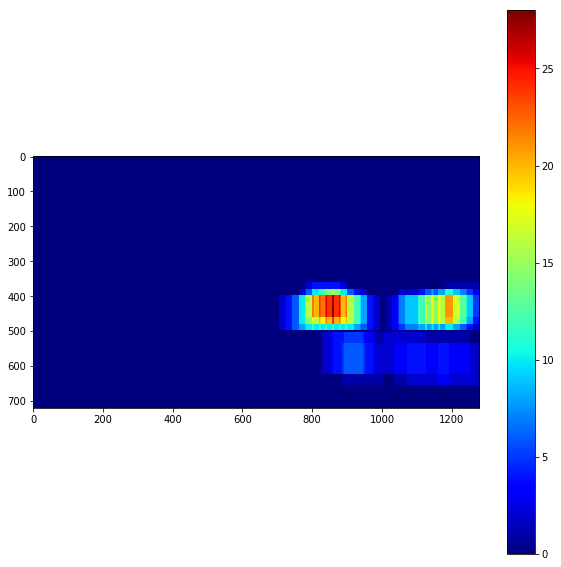

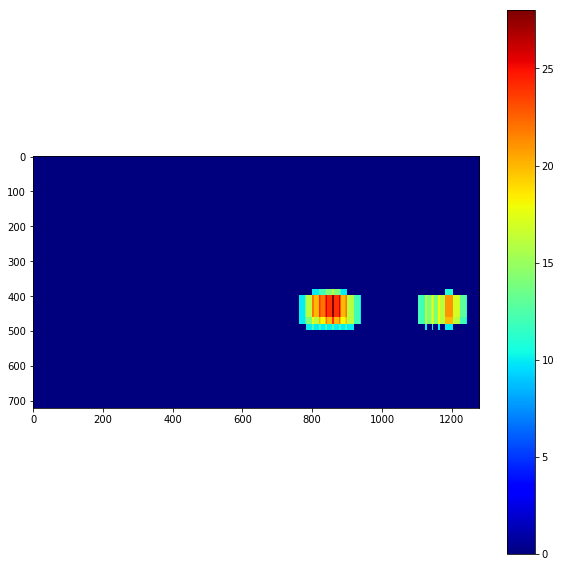

In [557]:
heat = heatmap(img, detected, min_thresh=0)
plt.figure(figsize=(10,10))
plt.imshow(heat, cmap='jet')
plt.colorbar()
plt.show()
heat = heatmap(img, detected, min_thresh=10)
plt.figure(figsize=(10,10))
plt.imshow(heat, cmap='jet')
plt.colorbar()
plt.show()

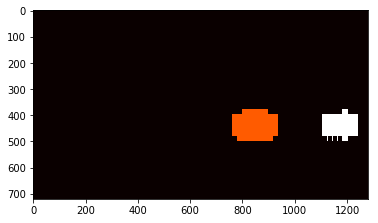

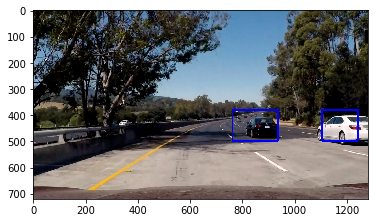

In [556]:
labels = label(heat)
label_img = labels[0].astype(np.uint8)
heatmap_boxes = draw_heatmap_boxes(np.copy(img), heat, 50)
plt.imshow(label_img, cmap='hot')
plt.show()

plt.imshow(heatmap_boxes)

In [540]:
def vid_pipeline(img):
    heat = np.zeros_like(img[:,:,0])
    detected = detect_cars(img, svc, X_scaler)
    draw_img_l = draw_detected_boxes(img, detected, color=(0, 255, 255), thickness=2)
    heat = heatmap(img, detected, min_thresh=10)
    heatmap_boxes = draw_heatmap_boxes(np.copy(img), heat, 40)
    return heatmap_boxes

In [541]:
from moviepy.editor import VideoFileClip

myclip = VideoFileClip('project_video.mp4')#.subclip(40,43)
output_vid = 'output.mp4'
clip = myclip.fl_image(vid_pipeline)
clip.write_videofile(output_vid, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<14:14,  1.48it/s]

  0%|          | 2/1261 [00:01<14:02,  1.49it/s]

 12%|█▏        | 152/1261 [01:40<11:58,  1.54it/s]


 24%|██▍       | 303/1261 [03:23<10:50,  1.47it/s]


 36%|███▌      | 454/1261 [05:03<08:44,  1.54it/s]


 48%|████▊     | 605/1261 [06:44<06:59,  1.57it/s]


 60%|█████▉    | 756/1261 [08:32<05:56,  1.42it/s]


 72%|███████▏  | 907/1261 [10:11<03:49,  1.54it/s]


 84%|████████▍ | 1057/1261 [11:55<02:16,  1.50it/s]


 96%|█████████▌| 1205/1261 [13:36<00:36,  1.53it/s]


100%|█████████▉| 1260/1261 [14:13<00:00,  1.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

